In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
data_path = '/Users/shenheng/Code/NN/Lab/data/lulu.csv'
data = pd.read_csv(data_path)
data.columns=['dertapx','dertapy','dertavx','dertavy','ifattacker']
data = data.sample(frac=1).reset_index(drop=True)# 数据扰乱
data = data.dropna(axis=0, how='any')
"""
df.dropna(axis=0,how='all')#删除表中全部为NaN的行
df.dropna(axis=0,how='any') #删除表中含有任何NaN的行
df.dropna(axis=1,how='all') #删除表中全部为NaN的列
"""
data

,dertapx,dertapy,dertavx,dertavy,ifattacker
0,-3.379384,27.284398,-1.064839,-0.059889,0.0
1,0.017489,30.049128,-0.000103,-0.177598,0.0
2,-3.713618,29.990191,-0.002124,0.017156,0.0
3,0.017598,30.235227,0.000012,0.019932,0.0
4,4.800375,-31.360075,-0.572702,-0.062129,0.0
...,...,...,...,...,...
25441,0.029102,-29.995521,0.000030,-0.031303,0.0
25442,2.933814,-35.814130,0.001228,-0.014995,0.0
25443,3.638251,-31.525057,0.005000,-0.043325,0.0
25444,-7.695923,62.150237,0.003165,-0.025563,0.0


In [3]:
from sklearn.preprocessing import StandardScaler # 通过减去均值并除以单位方差来标准化数据
# 数据归一化
scaler = StandardScaler() # fit求均值方差，transform求归一化数据
target_all = data['ifattacker'].to_numpy()
data_all = data.drop(['ifattacker'], axis=1)
data_all = scaler.fit_transform(data_all)
data_all = pd.DataFrame(data_all)
data_all

,0,1,2,3
0,0.002383,0.042266,-0.683857,-0.737925
1,0.000647,0.041408,-0.941874,0.184883
2,0.009707,-0.107143,-1.400020,0.465754
3,-0.002132,0.044187,0.545939,0.265781
4,0.000703,-0.060047,-1.517399,-0.225497
...,...,...,...,...
25440,-0.006409,0.093792,-1.272397,-0.300317
25441,-0.002133,0.044199,0.557402,-0.041092
25442,0.002707,0.054129,-0.967982,0.133649
25443,0.000664,-0.061099,0.553605,-0.055560


In [4]:
print(np.unique(target_all))

[0. 1.]


In [14]:
test_size = int(len(data_all)//10) #10/1的测试集
# 训练集
train_data = data_all[2*test_size : ]
train_label = target_all[2*test_size : ]

test_data = data_all[test_size : 2*test_size]
test_label = target_all[test_size : 2*test_size]

valid_data = data_all[: test_size]
valid_label = target_all[: test_size]

features = train_data
target = train_label
test_features = test_data
test_target = test_label

In [6]:
X = features.values
Y = target
Y = Y.astype(int)
Y = np.reshape(Y, [len(Y), 1])

input_size = 4
hidden_size = 10
output_size = 2
batch_size = 100
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.LogSoftmax(dim=1)
)
cost = torch.nn.NLLLoss() #损失函数
optimizer = torch.optim.SGD(neu.parameters(), lr=0.001) #优化算法

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size(数据量)行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1]  # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    # 比如三维张量，第一个是z，第二个是行第三个是列。出来的是一个两列的矩阵，第一列是纬度上的最值，第二列是维度上的位置
    rights = pred.eq(labels.data.view_as(pred)).sum()  # 将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    #  view_as(tensor)返回被视作与给定的tensor相同大小的原tensor。
    return rights, len(labels)  # 返回正确的数量和这一次一共比较了多少元素›

In [7]:
losses = []
records = []
epoch_size = 10 # 十个epoch
a = zip(train_data.values, train_label)
for epoch in range(epoch_size):
    # print(str(epoch) + "次：")
    for i, data in enumerate(zip(train_data.values, train_label)):
        x, y = data  #x为特征，y为标签
        x = torch.tensor(x, requires_grad=True, dtype=torch.float).view(1, -1) #重新构造形状，1行，-1列指从行来判断
        y = torch.tensor(np.array([y]), dtype=torch.long)
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = neu(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()

        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            # dataframe必须要取出values才能得到正确结果，不然的话得到的就是列数
            for j, val in enumerate(zip(valid_data.values, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad=True, dtype=torch.float).view(1, -1)
                y = torch.tensor(np.array([y]), dtype=torch.long)
                predict = neu(x)
                # 调用rightness函数计算准确度,对一个数据进行比较，正确得到1，错误得到0
                # 只输出一个的话，第一个为代表是否正确的0，1；第二个为代表比较了几个的1
                right = rightness(predict, y)
                rights.append(right) # rights里面是一个0101的数组，对应于校验集上数据的正确性
                loss1 = cost(predict, y)
                val_losses.append(loss1.data.numpy())
            # 因此可以计算校验集上的正确率
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            # 注意校验损失和训练损失为其中的均值
            print('第{}轮——损失为交叉熵均值：训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                            np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])  #记录下三者

第0轮——损失为交叉熵均值：训练损失：0.80, 校验损失：0.80, 校验准确率: 0.04
第0轮——损失为交叉熵均值：训练损失：0.35, 校验损失：0.22, 校验准确率: 0.96
第0轮——损失为交叉熵均值：训练损失：0.27, 校验损失：0.19, 校验准确率: 0.96
第0轮——损失为交叉熵均值：训练损失：0.24, 校验损失：0.18, 校验准确率: 0.96
第0轮——损失为交叉熵均值：训练损失：0.23, 校验损失：0.18, 校验准确率: 0.96
第0轮——损失为交叉熵均值：训练损失：0.22, 校验损失：0.18, 校验准确率: 0.96
第0轮——损失为交叉熵均值：训练损失：0.22, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.22, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.21, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.21, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第1轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.20, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.19, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.19, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.19, 校验损失：0.18, 校验准确率: 0.96
第2轮——损失为交叉熵均值：训练损失：0.19, 校验损失：0.18, 校验准确

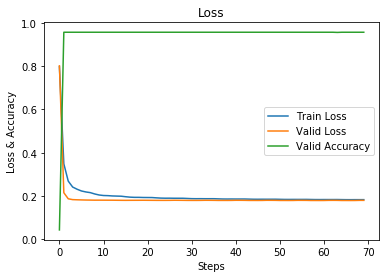

In [8]:
# %%
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label='Train Loss')
plt.plot(b, label='Valid Loss')
plt.plot(c, label='Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')

plt.legend()
plt.title('Loss')
plt.savefig('Loss_NLP.png', dpi=72)
plt.show()

In [15]:
# 在测试集上分批运行，并计算总的正确率
vals = []  # 记录准确率所用列表

# 对测试数据集进行循环
for data, target in zip(test_data.values, test_label):
    data, target = torch.tensor(data, dtype=torch.float).view(1, -1), torch.tensor(np.array([target]), dtype=torch.long)
    output = neu(data)  # 将特征数据喂入网络，得到分类的输出
    val = rightness(output, target)  # 获得正确样本数以及总样本数
    vals.append(val)  # 记录结果

# 计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
print("测试集正确率为：" + str(right_rate))

测试集正确率为：0.9555817610062893


In [4]:
import sys
a =  sys.path
for i in range(len(a)):
    print(a[i])
#print(sys.path)

/Users/shenheng/Code/NN/Lab
/Users/shenheng/Code/NN
/Users/shenheng/anaconda3/envs/Py/lib/python37.zip
/Users/shenheng/anaconda3/envs/Py/lib/python3.7
/Users/shenheng/anaconda3/envs/Py/lib/python3.7/lib-dynload

/Users/shenheng/anaconda3/envs/Py/lib/python3.7/site-packages
/Users/shenheng/anaconda3/envs/Py/lib/python3.7/site-packages/IPython/extensions
/Users/shenheng/.ipython
/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev
/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug
